# Tutorial 4: Horizontal Spatial Transcriptomics Integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. ST data were downloaded from https://www.10xgenomics.com/. Before inputting the model, alignment algorithm was implemented to align mouse anterior and posterior brain data. 

Please note that aligned position information must be saved in adata.obsm['spatial'] before running the model.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1jDmx8IjiGhOD__spuuhFB1fWVDJtv5CU.

In [29]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [30]:
from GraphST import GraphST

In [31]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [32]:
# the number of clusters
n_clusters = 26

## Reading data

In [33]:
# read data
#file_fold = './Mouse_Brain/' #please replace 'file_fold' with the download path
file_fold = '/home/yahui/anaconda3/work/CellCluster_DEC/data/Mouse_Brain_Merge_Anterior_Posterior/'
#adata = sc.read_h5ad(file_fold + 'mouse_anterior_posterior_brain_merged.h5ad')
adata = sc.read_h5ad(file_fold + 'filtered_feature_bc_matrix.h5ad')
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Implementing GraphST for multi-sample integration

In [34]:
# define model
model = GraphST.GraphST(adata, device=device, random_seed=50)

# run model
adata = model.train()

  1%|█                                                                                | 8/600 [00:00<00:08, 71.41it/s]

Begin to train ST data...


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 66.15it/s]


Optimization finished for ST data!


## Spatial clustering

After model training, the representation for spots are generated and used as input of clustering tool for spatial clustering. Here we provid three available kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [35]:
# clustering
from GraphST.utils import clustering

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool) 
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01) 

fitting ...
  |======================================================================| 100%


## Visualization

<AxesSubplot:title={'center':'Mouse Anterior & Posterior Brain (Section 1)'}, xlabel='spatial1', ylabel='spatial2'>

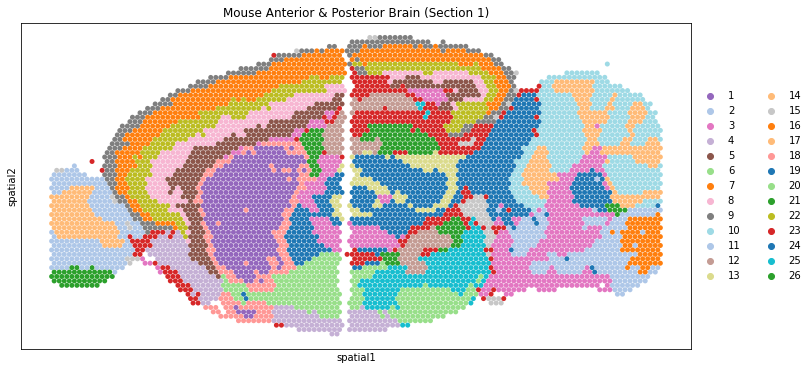

In [36]:
# plotting spatial clustering result
import matplotlib.pyplot as plt
import seaborn as sns
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
rgb_values = sns.color_palette("tab20", len(adata.obs['domain'].unique()))
color_fine = dict(zip(list(adata.obs['domain'].unique()), rgb_values))

plt.rcParams["figure.figsize"] = (12, 6)
sc.pl.embedding(adata, basis="spatial", 
                color="domain",
                s=100, 
                palette=color_fine, 
                show=False, 
                title='Mouse Anterior & Posterior Brain (Section 1)')